# **第二章 几何对象模型**   

地理空间的矢量表达中，用点、线、面（多边形）等几何对象来表达地理要素的几何形状。**Shapely**是GEOS(Geometry Engine - Open Source) 的Python接口，提供了矢量空间数据的**几何对象模型及相应的空间操作运算**。GEOS是JTS（Java Topology Suite）的C++实现，也是PostgreSQL的空间扩展PostGIS的几何引擎。**JTS和GEOS遵循OGC简单要素访问规范**。

本章主要阐述Shapely中的几何对象模型概述、空间谓词与空间关系、空间操作运算。

## **几何对象模型概述**

Shapely实现的基本几何类型有Point、LineString和Polygon。   
    
   * **Point**：表示空间中的单个点。点可以是二维（x，y）或三维（x，y，z）。    
   * **LineString**：表示连接在一起形成一条线的一系列点，至少由两个坐标元组的列表组成。   

   * **Polygon**：表示一个填充区域，该区域至少由三个坐标元组的列表和孔多边形（可能）列表组成，坐标元组构成外层环。  

```{figure} ./Resources/shapely几何类型示意图.png
:name: shapely几何类型示意图
:alt: shapely几何类型示意图
:width: 50%
:align: center
```
<center> 图2-1 shapely几何类型示意图 </center>
Shapely还提供了几何对象的集合类型：MultiPoint、MultiLineString 和MultiPolygon。   
    
   * **MultiPoint**：表示点的集合，由坐标元组列表组成。

   * **MultiLineString**：表示线几何的集合，由一系列类似线的列表组成。   

   * **MultiPolygon**：表示多边形的集合，该集合由构成多边形的一系列外环和空洞组成。   
    

### **Point**   

创建点仅需将x和y坐标（或可选的z坐标）传递到point()对象.

In [1]:
# 查看shapely包结构及组成
import shapely

In [2]:
# Import necessary geometric objects from shapely module
from shapely.geometry import Point, LineString, Polygon

# Create Point geometric object(s) with coordinates
point1 = Point(111.89, 25.78)
point2 = Point(115.69, 23.68)
point3 = Point(117.89, 26.78)
point3D = Point(111.89,25.78, 888.88) # Shapely是一个平面几何库，在几何分析中忽略z值。

In [3]:
# What is the type of the point?
print(point1)
print(point3D)
print(type(point1))

POINT (111.89 25.78)
POINT Z (111.89 25.78 888.88)
<class 'shapely.geometry.point.Point'>


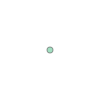

In [4]:
point1

#### **Point的属性与方法**   

点几何对象提供了内置的属性和方法可供访问，其中最常用的是能够提取点的坐标和计算点之间的欧几里德距离。   

提取一个点的坐标，有几种不同的方法：

In [5]:
# Get the coordinates
point_coords = point1.coords

# What is the type of this?
print(type(point_coords))

# Get x and y coordinates
xy = point_coords.xy
print("point_coords.xy type is:",type(xy))
print("point_coords.xy values is:", xy)

# Get x, y coordinates of Point1
x = point1.x
y = point1.y

print("point.x is :", x)
print("point.y is :", y)

<class 'shapely.coords.CoordinateSequence'>
point_coords.xy type is: <class 'tuple'>
point_coords.xy values is: (array('d', [111.89]), array('d', [25.78]))
point.x is : 111.89
point.y is : 25.78


**计算两点之间的距离**

In [6]:
# Calculate the distance between point1 and point2
point_dist = point1.distance(point2)

print("Distance between the points is {0:.2f} decimal degrees".format(point_dist))


Distance between the points is 4.34 decimal degrees


注：地理信息系统中距离

在Shapely中，距离是平面上两点之间的欧氏距离或线性距离。如果我们想计算地球表面的实际距离，则需要计算球体上的距离。通常情况下，地球的赤道半径为6378公里，极地半径为6356公里，即相差22公里。以下使用这两个半径计算两点之间的球面距离、以及两点之间的WGS84椭球面距离。
    
pyproj.Geod支持大地解算的正算和逆算，Geod类的初始化输入可以是椭球体参数，也可以是椭球体名称，如示例代码中的“WGS84”。

   * 正向变换：根据起始点的经度和纬度，加上前向的方位角和距离，确定终点的经度、纬度和后向方位角。   
   *lons2, lats2, back_az = geod.fwd(lons1, lats1, forward_az, dist)*    
   * 逆向变换：根据两点经纬度，计算前向、后向方位角和距离。   
   *forward_az, back_az, dist = geod.inv(lons1, lats1, lons2, lats2)*
   * 说明：以上角度单位为度，距离单位为米。

In [7]:
# law of cosines - determines the great-circle distance between two points 
# on a sphere given their longitudes and latitudes based on "basic math"
from math import acos,sin,cos,radians

p1x=radians(point1.x)
p1y=radians(point1.y)
p2x=radians(point2.x)
p2y=radians(point2.y)            
distance = acos(sin(p1y)*sin(p2y)+cos(p1y)*cos(p2y)*cos(p2x-p1x))*6378

print( "{0:8.4f} for equatorial radius in km".format(distance))
distance = acos(sin(p1y)*sin(p2y)+cos(p1y)*cos(p2y)*cos(p2x-p1x))*6356

print( "{0:8.4f} for polar radius in km".format(distance))

# with pyproj
import pyproj

geod = pyproj.Geod(ellps='WGS84')

angle1,angle2,distance = geod.inv(point1.x, point1.y, point2.x, point2.y)

print ("{0:8.4f} for ellipsoid WGS84 in km".format(distance/1000))

449.6977 for equatorial radius in km
448.1465 for polar radius in km
449.3002 for ellipsoid WGS84 in km


### **LineString**   

创建LineString对象与创建点的方式非常相似。可以使用Point点对象列表或传递坐标元组来创建线几何对象。

In [8]:
# Create a LineString from our Point objects
line = LineString([point1, point2, point3])

# It is also possible to use coordinate tuples having the same outcome
line2 = LineString([(111.89, 25.78), (115.69, 23.68), (117.89, 26.78)])
# Let’s see how our LineString looks like
print(line)
print(line2)

print(type(line))


LINESTRING (111.89 25.78, 115.69 23.68, 117.89 26.78)
LINESTRING (111.89 25.78, 115.69 23.68, 117.89 26.78)
<class 'shapely.geometry.linestring.LineString'>


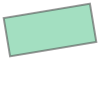

In [9]:
line.minimum_rotated_rectangle

#### **LineString的属性与方法**   

LineString对象有许多有用的内置属性和功能。例如，可以提取线串的坐标或长度，计算线的质心，沿线以特定距离创建点，计算线到指定点的最近距离，并简化几何图形。

以下代码提取线串的相关信息：

In [10]:
# Get x and y coordinates of the line
lxy = line.xy
print("line的xy坐标：", lxy)

# Extract x coordinates
line_x = lxy[0]
# Extract y coordinates 
line_y = line.xy[1]

print("line的x坐标：", line_x)
print("line的y坐标：", line_y)

line的xy坐标： (array('d', [111.89, 115.69, 117.89]), array('d', [25.78, 23.68, 26.78]))
line的x坐标： array('d', [111.89, 115.69, 117.89])
line的y坐标： array('d', [25.78, 23.68, 26.78])


In [11]:
# Get the lenght of the line
l_length = line.length

# Get the centroid of the line
l_centroid = line.centroid

# What type is the centroid?
centroid_type = type(l_centroid)

# Print the outputs
print("Length of our line: {0:.2f}".format(l_length))
print("Centroid of our line: ", l_centroid)
print("Type of the centroid:", centroid_type)

Length of our line: 8.14
Centroid of our line:  POINT (115.19046454302645 24.96341075717108)
Type of the centroid: <class 'shapely.geometry.point.Point'>


#### **线性参考（Linear Referencing）**   

使用一维参照系统沿线性要素（如LineStrings、MultiLineStrings）指定位置非常有用。Shapely支持基于长度或距离的线性参考，计算沿几何对象到给定点投影的距离，或计算沿几何对象在给定距离上的点。   

   * **object.interpolate**(distance\[, normalized=False\])：返回沿线性几何对象指定距离处的**点**。如果normalized参数为真，则距离将被解释为占几何对象整个长度的多少，如0.5为整个长度的一半。
   * **object.project**(other\[, normalized=False\])：返回沿此几何对象到距离另一个对象最近的点的**距离**。如果normalized参数为真，则距离将被解释为占几何对象整个长度的多少，如0.5为整个长度的一半。project()方法是interpolate()的逆方法。

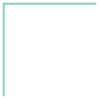

In [12]:
line = LineString([(0, 0), (0, 1), (1, 1)])
line

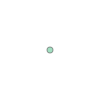

In [13]:
ip = line.interpolate(1.5)
ip

In [14]:
ip.wkt

'POINT (0.5 1)'

In [15]:
line.interpolate(0.75, normalized=True).wkt

'POINT (0.5 1)'

In [16]:
line.project(ip)

1.5

In [17]:
line.project(ip, normalized=True)

0.75

In [18]:
list(line.coords)

[(0.0, 0.0), (0.0, 1.0), (1.0, 1.0)]

In [19]:
# 可以使用线性参照方法以指定的距离切割线几何对象。

def cut(line, distance):
    # Cuts a line in two at a distance from its starting point
    if distance <= 0.0 or distance >= line.length:
        return [LineString(line)]
    coords = list(line.coords)
    for i, p in enumerate(coords):
        pd = line.project(Point(p))
        if pd == distance:
            return [
                LineString(coords[:i+1]),
                LineString(coords[i:])]
        if pd > distance:
            cp = line.interpolate(distance)
            return [
                LineString(coords[:i] + [(cp.x, cp.y)]),
                LineString([(cp.x, cp.y)] + coords[i:])]
line = LineString([(0, 0), (1, 0), (2, 0), (3, 0), (4, 0), (5, 0)])
print([list(x.coords) for x in cut(line, 1.0)])

[[(0.0, 0.0), (1.0, 0.0)], [(1.0, 0.0), (2.0, 0.0), (3.0, 0.0), (4.0, 0.0), (5.0, 0.0)]]


In [20]:
print([list(x.coords) for x in cut(line, 2.5)])

[[(0.0, 0.0), (1.0, 0.0), (2.0, 0.0), (2.5, 0.0)], [(2.5, 0.0), (3.0, 0.0), (4.0, 0.0), (5.0, 0.0)]]


### **Polygon**   

创建多边形对象与创建Point和LineString的逻辑相同，但多边形对象**只接受坐标元组作为输入**。多边形至少需要三个坐标元组。

In [21]:
# Create a Polygon from the coordinates
poly = Polygon([(111.89, 25.78), (115.69, 23.68), (117.89, 26.78)])

# 也可以使用已有的点对象，但多边形对象需要x，y坐标作为输入
poly2 = Polygon([[p.x, p.y] for p in [point1, point2, point3]])

# Geometry type can be accessed as a String
poly_type = poly.geom_type

# Using the Python's type function gives the type in a different format
poly_type2 = type(poly)

# Let's see how our Polygon looks like
print(poly)
print(poly2)
print("多边形的几何类型:", poly_type)
print("多边形的对象类型:", poly_type2)

POLYGON ((111.89 25.78, 115.69 23.68, 117.89 26.78, 111.89 25.78))
POLYGON ((111.89 25.78, 115.69 23.68, 117.89 26.78, 111.89 25.78))
多边形的几何类型: Polygon
多边形的对象类型: <class 'shapely.geometry.polygon.Polygon'>


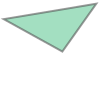

In [22]:
poly

请注意：多边形的坐标由双圆括号包围。这是因为多边形内部可能有孔。可以使用外部坐标和内部坐标（可选）构建多边形，其中内部坐标在多边形内创建孔。

创建带空洞的多边形：

In [23]:
# 外环坐标元组列表
world_exterior = [(-180, 90), (-180, -90), (180, -90), (180, 90)]

# 内部空洞坐标元组列表，注意：可能有多个孔，需要提供一个孔列表[[......],...[......]]
hole = [[(-170, 80), (-170, -80), (170, -80), (170, 80)]]

# World without a hole
world = Polygon(shell=world_exterior)

# Now we can construct our Polygon with the hole inside
world_has_a_hole = Polygon(shell=world_exterior, holes=hole)

print(world)

print(world_has_a_hole)

type(world_has_a_hole)

POLYGON ((-180 90, -180 -90, 180 -90, 180 90, -180 90))
POLYGON ((-180 90, -180 -90, 180 -90, 180 90, -180 90), (-170 80, -170 -80, 170 -80, 170 80, -170 80))


shapely.geometry.polygon.Polygon

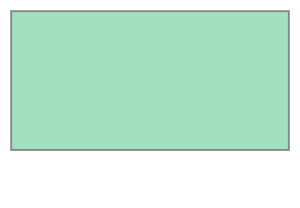

In [24]:
world

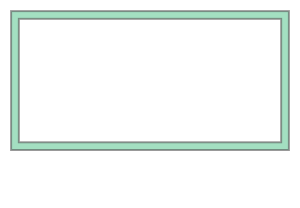

In [25]:
world_has_a_hole

#### **Polygon的属性与方法**   

多边形的主要属性有：面积、质心、MBR、外部和外部长度等。   

In [26]:
# Get the centroid of the Polygon
world_centroid = world.centroid

# Get the area of the Polygon
world_area = world.area

# Get the bounds of the Polygon (i.e. bounding box)
world_bbox = world.bounds

# Get the exterior of the Polygon
world_ext = world.exterior

# Get the length of the exterior
world_ext_length = world_ext.length
print("Poly centroid: ", world_centroid)
print("Poly Area: ", world_area)
print("Poly Bounding Box: ", world_bbox)
print("Poly Exterior: ", world_ext)
print("Poly Exterior Length: ", world_ext_length)

Poly centroid:  POINT (0 0)
Poly Area:  64800.0
Poly Bounding Box:  (-180.0, -90.0, 180.0, 90.0)
Poly Exterior:  LINEARRING (-180 90, -180 -90, 180 -90, 180 90, -180 90)
Poly Exterior Length:  1080.0


### **从文本文件中读取XY坐标**   

我们可以使用Python中常用的pandas包读取文本文件中的坐标数据，并转换为DataFrame类型，然后根据DataFrame中的坐标数据创建点几何对象。

In [27]:
import pandas as pd

df = pd.read_csv('../data/globalcities.csv', sep=';', encoding='latin1')
print(type(df))
df.head(5)
 

<class 'pandas.core.frame.DataFrame'>


,Country or area,Urban Agglomeration,Latitude,Longitude,Population_2015,Unnamed: 5
0,Japan,Tokyo,35.689500,139.691710,38001018,NaN
1,India,Delhi,28.666670,77.216670,25703168,NaN
2,China,Shanghai,31.220000,121.460000,23740778,NaN
3,Brazil,S?o Paulo,-23.550000,-46.640000,21066245,NaN
4,India,Mumbai (Bombay),19.073975,72.880838,21042538,NaN


In [28]:
# 根据df(DataFrame)中的Longitude、Latitude数据创建点几何对象。

def make_point(row): 
    return Point(row['Longitude'], row['Latitude'])

# apply()方法中的参数axis=1，表示逐行向下处理
df['points'] = df.apply(make_point, axis=1)

print(df.head(5))

  Country or area Urban Agglomeration   Latitude   Longitude  Population_2015  \
0           Japan               Tokyo  35.689500  139.691710         38001018   
1           India               Delhi  28.666670   77.216670         25703168   
2           China            Shanghai  31.220000  121.460000         23740778   
3          Brazil           S?o Paulo -23.550000  -46.640000         21066245   
4           India     Mumbai (Bombay)  19.073975   72.880838         21042538   

   Unnamed: 5                       points  
0         NaN    POINT (139.69171 35.6895)  
1         NaN    POINT (77.21667 28.66667)  
2         NaN         POINT (121.46 31.22)  
3         NaN        POINT (-46.64 -23.55)  
4         NaN  POINT (72.880838 19.073975)  


### **几何集合对象**   

在某些情况下，单个地理要素的几何形状由多部分(Multi Part)组成，如MultiPoint、MultiLineString、MultiPolygon，这些集合类型对于建模某些类型的要素非常有用。Y形线要素（如道路）或多个多边形（如岛等）可以通过相应地使用MultiLineString或MultiPolygon很好地作为一个整体表达。   

可以通过以下方式来构建几何集合对象：

In [29]:
# Import collections of geometric objects + bounding box
from shapely.geometry import MultiPoint, MultiLineString, MultiPolygon, box

# Create a MultiPoint object of our points 1,2 and 3
multi_point = MultiPoint([point1, point2, point3])

# It is also possible to pass coordinate tuples inside
multi_point2 = MultiPoint([(111.89, 25.78), (115.69, 23.68), (117.89, 26.78)])

# We can also create a MultiLineString with two lines
line1 = LineString([point1, point2])

line2 = LineString([point2, point3])

multi_line = MultiLineString([line1, line2])

west_exterior = [(-180, 90), (-180, -90), (0, -90), (0, 90)]

west_hole = [[(-170, 80), (-170, -80), (-10, -80), (-10, 80)]]

# Create the Polygon
west_poly = Polygon(shell=west_exterior, holes=west_hole)

min_x, min_y = 0, -90
max_x, max_y = 180, 90

# Create the polygon using box() function
east_poly_box = box(minx=min_x, miny=min_y, maxx=max_x, maxy=max_y)

# Let's create our MultiPolygon. We can pass multiple Polygon -objects into our MultiPolygon as a list
multi_poly = MultiPolygon([west_poly, east_poly_box])

print("MultiPoint:", multi_point)

print("MultiLine: ", multi_line)

print("Bounding box: ", east_poly_box)

print("MultiPoly: ", multi_poly)

MultiPoint: MULTIPOINT (111.89 25.78, 115.69 23.68, 117.89 26.78)
MultiLine:  MULTILINESTRING ((111.89 25.78, 115.69 23.68), (115.69 23.68, 117.89 26.78))
Bounding box:  POLYGON ((180 -90, 180 90, 0 90, 0 -90, 180 -90))
MultiPoly:  MULTIPOLYGON (((-180 90, -180 -90, 0 -90, 0 90, -180 90), (-170 80, -170 -80, -10 -80, -10 80, -170 80)), ((180 -90, 180 90, 0 90, 0 -90, 180 -90)))


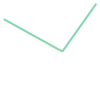

In [30]:
multi_line

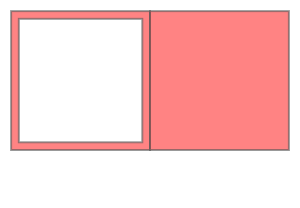

In [31]:
multi_poly

**几何集合对象的属性与方法**   

In [32]:
# Convex Hull of our MultiPoint
convex = multi_point.convex_hull

# How many lines do we have inside our MultiLineString?
lines_count = len(multi_line)

# Let's calculate the area of our MultiPolygon
multi_poly_area = multi_poly.area

# 可以访问几何集合中的不同项。
west_area = multi_poly[0].area

# 可以检测几何对象是否有效，多边形的环不能有重叠，线几何不能自相交
valid = multi_poly.is_valid

print("Convex hull of the points: ", convex)
print("Number of lines in MultiLineString:", lines_count)
print("Area of our MultiPolygon:", multi_poly_area)
print("Area of our Western Hemisphere polygon:", west_area)
print("Is polygon valid?: ", valid)

TypeError: object of type 'MultiLineString' has no len()

### **几何对象通用属性和方法**   

几何对象通用属性和方法如下：
   * object.area -- 返回几何对象的面积(float) 。  
   * object.bounds -- 返回几何对象的MBR (minx, miny, maxx, maxy) 。  
   * object.length -- 返回几何对象的长度。   
   * object.minimum_clearance -- 返回可移动节点以生成无效几何对象的最小距离。这可以被认为是几何对象稳健性的度量，其中最小间隙的较大值表示更稳健的几何结构。如果几何对象（如点）不存在最小间隙，则返回math.infinity。
   * object.geom_type -- 返回几何对象的字符串几何类型。    
   * object.distance(other) -- 返回几何对象与其它几何对象(other)的最短距离(float)。   
   * object.hausdorff_distance(other) -- 返回几何对象与其它几何对象(other)的Hausdorff距离。两个几何体之间的Hausdorff距离是任意一个几何对象上的一个点与另一个几何对象上的最近点之间的最远距离。   
   * object.representative_point() -- 返回一个廉价计算的点，该点保证位于几何对象内。   
 

In [ ]:
from shapely.geometry import Polygon
poly = Polygon([[0, 0], [1, 0], [1, 1], [0, 1], [0, 0]])
poly

In [ ]:
poly.minimum_clearance

In [ ]:
Point(0, 0).geom_type

In [ ]:
print((type(Point(0, 0))))

In [ ]:
Point(0,0).distance(Point(1,1))

In [ ]:
point = Point(1, 1)
line = LineString([(2, 0), (2, 4), (3, 4)])

In [ ]:
point

In [ ]:
line

In [ ]:
point.hausdorff_distance(line)

In [ ]:
point.distance(Point(3, 4))

In [ ]:
donut = Point(0, 0).buffer(2.0).difference(Point(0, 0).buffer(1.0))
donut.centroid.wkt

In [ ]:
donut

In [ ]:
donut.centroid

In [ ]:
donut.representative_point()

In [ ]:
donut.representative_point().wkt

## **空间谓词与空间关系**   
    
几何对象提供了标准谓词作为属性（一元谓词）和方法（二元谓词）。无论一元还是二元谓词，都返回True或False。   

### **一元谓词（Unary Predicates）**   

标准的一元谓词实现为几何对象的只读属性。   
   * **object.has_z**: 如果要素不仅具有x和y坐标，还具有z坐标的3D（或所谓的2.5D）几何图形，则返回True。   
   * **object.is_ccw**: 如果坐标按逆时针方向排列（用正号的面积包围一个区域带），则返回True。此方法仅适用于LinearRing对象。   
   * **object.is_empty**: 如果要素的内部（interior）和边界（boundary）都为空集，则返回True。   
   * **object.is_ring**: 如果要素是闭合的简单LineString，则返回True。闭合线要素的边界（boundary）为空集。此属性适用于LineString和LinearRing实例，对其他实例没有意义。   
   * **object.is_simple**: 如果要素没有自相交，则返回True。该属性仅对LineString和LinearRing有意义。
   * **object.is_valid**: 如果要素符合OGC简单要素访问规范意义上的“有效”，则返回True。一个有效的LinearRing不能自交叉，或在单个点相接（touch）。有效的多边形不能有任何重叠的外环或内环。有效的MultiPolygon不能有任何重叠的多边形。   
 

In [ ]:
Point(0, 0).has_z

In [ ]:
Point(0, 0, 0).has_z

In [ ]:
from shapely.geometry import LinearRing

LinearRing([(1,0), (1,1), (0,0)]).is_ccw

In [ ]:
# A ring with an undesired orientation can be reversed like this:

ring = LinearRing([(0,0), (1,1), (1,0)])
ring.is_ccw

In [ ]:
ring.coords = list(ring.coords)[::-1]
ring.is_ccw

In [ ]:
Point().is_empty

In [ ]:
Point(0, 0).is_empty

In [ ]:
line = LineString([(0, 0), (1, 1), (1, -1)])
line

In [ ]:
line.is_ring

In [ ]:
ring = LinearRing([(0, 0), (1, 1), (1, -1)])
ring

In [ ]:
ring.is_ring

In [ ]:
line = LineString([(0, 0), (1, 1), (1, -1), (0, 1)])
line

In [ ]:
line.is_simple

In [ ]:
poly = MultiPolygon([Point(0, 0).buffer(2.0), Point(1, 1).buffer(2.0)])
poly

In [ ]:
poly.is_valid

### **二元谓词（Binary Predicates）**   

标准二元谓词作为方法实现。二元谓词用于检测两个几何对象之间的拓扑关系、基于集合理论的关系。二元谓词都以另一个几何对象作为参数，并返回True或False。   
   *  **object.__eq__(other)**: 如果两个对象具有相同的几何类型，并且两个对象的坐标精确匹配，则返回True。   
   *  **object.equals(other)**: 如果对象的边界、内部和外部与其他对象的边界、内部和外部一致，则返回True。    
   传递给对象构造函数的坐标是这些集合的一部分，但不是集合的整体。例如，等效线的构造可以不同。   
   * **object.almost_equals(other[, decimal=6])**: 如果对象在指定小数点精度的所有点上都近似等于其它对象上的所有点，则返回True。     
   * **object.contains(other)**: 如果该对象包含其它几何对象，则返回True。即：如果其它几何对象没有点位于该几何对象的外部，且其他几何对象内部至少有一个点位于该几何对象内部，则返回True。该谓词适用于所有几何类型，与within（）相反。表达式a.contains(b) == b.within(a).   
   * **object.within(other)**: 如果对象的边界和内部仅与另一个对象的内部（而不是其边界或外部）相交，则返回True。a.within(b) == b.contains(a)   
   * **object.crosses(other)**: 如果该对象穿越其它对象，则返回True，如线穿越面。即，如果该对象的内部与另一个对象内部相交但不包含该内部，并且相交的维度小于其中一个的维度，则返回True。
   * **object.disjoint(other)**: 如果对象的边界和内部与另一个对象的边界和内部完全不相交，则返回True。    
   * **object.intersects(other)**: 如果对象的边界或内部以任何方式与其他对象的边界或内部相交，则返回True。换句话说，如果几何对象有共同的边界或内部点，它们就会相交。     
   * **object.overlaps(other)**: 如果两个相同几何维度的几何对象具有多个但不是所有的公共点，且它们的内部交集也具有相同的几何维度，则返回True。   
   * **object.touches(other)**: 如果两个几何对象至少有一个公共点，并且它们的内部不与另一个的任何部分相交，则返回True。    

In [ ]:
a = LineString([(0, 0), (1, 1)])
b = LineString([(0, 0), (0.5, 0.5), (1, 1)])
c = LineString([(0, 0), (0, 0), (1, 1)])
a.equals(b)

In [ ]:
a == b

In [ ]:
b.equals(c)

In [ ]:
b == c

In [ ]:
coords = [(0, 0), (1, 1)]
LineString(coords).contains(Point(0.5, 0.5))

In [ ]:
Point(0.5, 0.5).within(LineString(coords))

In [ ]:
LineString(coords).contains(Point(1.0, 1.0))

In [ ]:
LineString(coords).crosses(LineString([(0, 1), (1, 0)]))

In [ ]:
LineString(coords).crosses(Point(0.5, 0.5))

In [ ]:
Point(0, 0).disjoint(Point(1, 1))

a = LineString([(0, 0), (1, 1)])
b = LineString([(1, 1), (2, 2)])
a.touches(b)

### **九交模型关系**   

两个几何对象之间的空间关系通常可以通过基于维数扩展的九交模型（DE-9IM）即九交矩阵来表达，反过来，也可以给定一个九交矩阵（或对应的字符串），来检测两个几何对象是否满足九交矩阵对应的空间关系。   
* **object.relate(other)**: 返回该对象的内部、边界、外部和其他几何对象的内部、边界、外部之间关系的DE-9IM矩阵的字符串表示。   
* **object.relate_pattern(other, pattern)**: 如果几何对象空间关系的DE-9IM字符串满足pattern模式，则返回True，否则返回False。relate_pattern()将两个几何对象空间关系的DE-9IM字符串与指定的模式进行比较，如果字符串与模式匹配，则返回True，否则返回False。指定的模式可以是完全匹配（0、1或2）、布尔匹配（T或F）或```通配符（*）```。例如，within谓词的模式是```T******FF*```。   

In [ ]:
Point(0, 0).relate(Point(1, 1))

In [ ]:
Point(0, 0).relate(LineString([(0, 0), (1, 1)]))

In [7]:
point = Point(0.5, 0.5)
square = Polygon([(0, 0), (0, 1), (1, 1), (1, 0)])
square.relate_pattern(point, 'T*****FF*')

True

In [ ]:
point.within(square)

In [ ]:
# Note that the order or the geometries is significant, as demonstrated below. 
# In this example the square contains the point, but the point does not contain the square.
point.relate(square)

In [ ]:
square.relate(point)

## **空间操作运算**   

Shapely还提供了空间操作运算来产生新的几何对象。   
    
### **基于集合理论的操作运算**   

几乎每个二元谓词方法都有一个对应的空间操作运算返回一个新的几何对象。此外，几何对象的边界为只读属性。
空间操作运算总是返回一个几何对象。例如，不相交几何对象的交集将返回空的GeometryCollection，而不是None或False。若要测试一个几何对象是否为空，可以使用is_empty属性。   
* **object.boundary**：返回几何对象的边界。多边形的边界为线（即多边形的边界环），线的边界是点的集合（即线几何的端点），点的边界是空集（null）。   
    

In [ ]:
coords = [((0, 0), (1, 1)), ((-1, 0), (1, 0))]
lines = MultiLineString(coords)
lines

In [ ]:
lines.boundary

In [ ]:
print(list(lines.boundary))

In [ ]:
list(lines.boundary)

In [ ]:
print(lines.boundary.boundary)

* **object.centroid**：返回几何对象的质心(point)。   

In [ ]:
LineString([(0, 0), (1, 1)]).centroid

In [ ]:
LineString([(0, 0), (1, 1)]).centroid.wkt

* **object.difference(other)**: 该几何对象去除与其它几何对象的公共部分。   

In [ ]:
a = Point(1, 1).buffer(1.5)
a

In [ ]:
b = Point(2, 1).buffer(1.5)
b

In [ ]:
a.difference(b)

* **object.intersection(other)**: 返回两个几何对象的交集（即公共部分）。   

In [ ]:
a = Point(1, 1).buffer(1.5)
b = Point(2, 1).buffer(1.5)
a.intersection(b)

* **object.symmetric_difference(other)**: 去除两个几何对象的公共部分，其余部分保留。  

In [ ]:
a = Point(1, 1).buffer(1.5)
b = Point(2, 1).buffer(1.5)
a.symmetric_difference(b)

* **object.union(other)**: 返回两个几何对象的并集（即所有部分）。   


In [ ]:
a = Point(1, 1).buffer(1.5)
b = Point(2, 1).buffer(1.5)
a.union(b)

In [ ]:
a.union(b).boundary

In [ ]:
a.boundary.union(b.boundary)

* **object.buffer(distance, resolution=16, cap_style=1, join_style=1, mitre_limit=5.0, single_sided=False)**: 返回几何对象给定距离的缓冲区多边形。   
   **cap_style**参数: 用于确定线末端缓冲类型：1 (round，圆头), 2 (flat, 扁平), 3 (square，方形)，对应shapely.geometry.CAP_STYLE的值。    
   **join_style**参数: 用于确定线段之间连接类型：1 (round，圆头), 2 (mitre，锐角斜接), 3 (bevel，平头斜切)，对应shapely.geometry.JOIN_STYLE 的值。   
   可选的**resolution参数**：确定用于表达四分之一圆弧的线段数。   
   **distance**：正距离具有扩张效应，正常的内外缓冲；负距离表现为侵蚀效应，一般仅做内缓冲。   

```{figure} ./Resources/buffer.png
:name: buffer
:alt: buffer
:width: 50%
:align: center
```
<center>图2-2 创建缓冲区示意图</center>           

   **single_sided**: 为True，仅做单边缓冲；distance为正，做左边缓冲；distance为负，做右边缓冲。   
```{figure} ./Resources/buffer_single_side.png
:name: buffer_single_side
:alt: buffer_single_side
:width: 50%
:align: center
```
<center>图2-3 创建单边缓冲区示意图</center>                  


In [ ]:
from shapely.geometry import CAP_STYLE, JOIN_STYLE
CAP_STYLE.flat

In [ ]:
JOIN_STYLE.bevel

In [ ]:
line = LineString([(0, 0), (1, 1), (0, 2), (2, 2), (3, 1), (1, 0)])
line

In [ ]:
dilated = line.buffer(0.5)
dilated

In [ ]:
eroded = dilated.buffer(-0.3)
eroded

In [ ]:
line = LineString([(0, 0), (1, 1), (0, 2), (2, 2), (3, 1), (1, 0)])
left_hand_side = line.buffer(0.5, single_sided=True)
left_hand_side

In [ ]:
right_hand_side = line.buffer(-0.3, single_sided=True)
right_hand_side

   * **object.convex_hull**: 返回几何对象（构成几何对象的点数>=3）的最小凸多边形；点数为2时，最小凸多边形退化为一线段；点数为1时，最小凸多边形退化为一个点。   

In [ ]:
Point(0, 0).convex_hull

In [ ]:
MultiPoint([(0, 0), (1, 1)]).convex_hull

In [ ]:
MultiPoint([(0, 0), (1, 1), (1, -1)]).convex_hull

* **object.envelope**: 返回几何对象的最小外包矩形MBR，MBR的两边平行于坐标轴。   

In [ ]:
Point(0, 0).envelope

In [ ]:
MultiPoint([(0, 0), (1, 1)]).envelope

* **object.minimum_rotated_rectangle**: 返回最小外包矩形，不要求与坐标轴平行，可旋转。  

In [ ]:
Point(0, 0).minimum_rotated_rectangle

In [ ]:
MultiPoint([(0,0),(1,1),(2,0.5)]).minimum_rotated_rectangle

* **object.parallel_offset(distance, side, resolution=16, join_style=1, mitre_limit=5.0)**: 返回距离对象右侧或左侧一定距离的LineString或MultiLineString几何对象。   

   **distance**参数：必须为正的浮点数。  
   **side**参数：为‘left’ 或 ‘right’. ‘left’ 、 ‘right’是根据LineString的给定几何点的方向来确定的。右侧偏移，按与原始线串或线环相反的方向返回，而左侧偏移，按与原始线串或线环相同的方向返回。   
   **resolution**参数：确定用于表达四分之一圆弧的线段数。   
   **join_style**参数：用于线段之间连接类型：1 (round，圆头), 2 (mitre，锐角斜接), 3 (bevel，平头斜切)。   
   **mitre_limit**参数：用于控制斜接角（mitre）。平行线的转角将比斜接样式的大多数地方离原始位置更远。此距离与指定距离**distance**的比值为斜接比。比例超过限制的角将被平头斜切（bevel）。
   该方法仅适用于LinearRing和LineString.      

```{figure} ./Resources/对象平行偏移示意图.png
:name: 对象平行偏移示意图
:alt: 对象平行偏移示意图
:width: 50%
:align: center
```        
<center>图2-4 对象平行偏移示意图</center>          

* **object.simplify(tolerance, preserve_topology=True)**: 返回简化后的几何对象。    
   简化对象中的所有点都将在原始几何图形的容差范围内。默认情况下，使用较慢的算法来保留拓扑。如果preserve topology设置为False，则使用更快的Douglas-Peucker算法。   

```{figure} ./Resources/对象简化示意图.png
:name: 对象简化示意图
:alt: 对象简化示意图
:width: 50%
:align: center
```        

<center>图2-5 对象简化示意图</center>          

In [ ]:
p = Point(0.0, 0.0)
x = p.buffer(1.0)
x.area

In [ ]:
len(x.exterior.coords)

In [ ]:
s = x.simplify(0.05, preserve_topology=False)
s.area

In [ ]:
len(s.exterior.coords)

### **其它操作运算**    

   * **shapely.ops.polygonize(lines)**: 由线几何生成多边形几何对象，返回由输入线构造的多边形的迭代器。      

In [ ]:
from shapely.geometry import MultiLineString, MultiPolygon, MultiPoint
from shapely.ops import polygonize, polygonize_full, linemerge, unary_union, triangulate
lines = MultiLineString([
    ((0, 0), (1, 1)),
    ((0, 0), (0, 1)),
    ((0, 1), (1, 1)),
    ((1, 1), (1, 0)),
    ((1, 0), (0, 0))
])
lines

In [ ]:
polys = polygonize(lines)
polylist = list(polys)
polylist[0] 

In [ ]:
mp = MultiPolygon(polylist)
mp

   * **shapely.ops.polygonize_full(lines)**: 返回多边形及剩余的线几何。   

In [ ]:
lines =  MultiLineString([
    ((0, 0), (4, 0)),
    ((4, 0), (4, 4)),
    ((4, 4), (0, 4)),
    ((0, 4), (0, 0)),
    ((4, 0), (8, 0)),
    ((8, 0), (8, 4)),
    ((8, 4), (4, 4)),
    ((4, 4), (4, 0)),
    ((5, 7), (8, 11)),
    ((10, 5), (8, 10))
]) 
lines

In [ ]:
result, dangles, cuts, invalids = polygonize_full(lines)
result

In [ ]:
cuts

In [ ]:
dangles

In [ ]:
dangles.wkt

   * **shapely.ops.linemerge(lines)**: 返回合并后的线几何：LineString或MultiLineString。   

In [ ]:
ml = linemerge(lines)
ml

In [ ]:
len(ml)

In [ ]:
print(list(linemerge(lines)))

   * **shapely.ops.unary_union(geoms)**: 返回geoms的并集。  

In [ ]:
polygons = [Point(i, 0).buffer(0.7) for i in range(5)]
mp = MultiPolygon(polygons)
mp

In [ ]:
poly = unary_union(polygons)
poly

   * **shapely.ops.triangulate(geom, tolerance=0.0, edges=False)**: 构建三角网。   

In [ ]:
points = MultiPoint([(0, 0), (1, 1), (0, 2), (2, 2), (3, 1), (1, 0)])
triangles = triangulate(points)
mp = MultiPolygon(triangles)
mp

In [ ]:
print([triangle.wkt for triangle in triangles])

In [ ]:
type(triangles)

   * **shapely.ops.nearest_points(geom1, geom2)**: 返回输入几何图形中最近点的元组。返回点的顺序与输入几何图形的顺序相同。   

In [ ]:
from shapely.ops import nearest_points 

triangle = Polygon([(0, 0), (1, 0), (0.5, 1), (0, 0)])
triangle

In [ ]:
square = Polygon([(0, 2), (1, 2), (1, 3), (0, 3), (0, 2)])
square

In [ ]:
[o.wkt for o in nearest_points(triangle, square)]

   * **shapely.ops.snap(geom1, geom2, tolerance)**: 将geom1中的顶点捕捉到geom2中的顶点。将返回捕捉的几何图形的副本，不会修改输入几何图形。    

In [ ]:
from shapely.ops import snap

square = Polygon([(1,1), (2, 1), (2, 2), (1, 2), (1, 1)])
square

In [ ]:
line = LineString([(0,0), (0.8, 0.8), (1.8, 0.95), (2.6, 0.5)])
line

In [ ]:
result = snap(line, square, 0.5)
result

In [ ]:
result.wkt

   * **shapely.ops.shared_paths(geom1, geom2)**:    
    当两个几何图形都为LineStrings时，查找geom1和geom2之间的共享路径。     
    当两个几何图形为GeometryCollection时，返回两个元素。第一个元素是包含两个输入方向相同的共享路径，第二个元素是包含两个输入方向相反的共享路径。   

In [ ]:
import shapely.ops

g1 = LineString([(0, 0), (10, 0), (10, 5), (20, 5)])
g2 = LineString([(5, 0), (30, 0), (30, 5), (0, 5)])
forward, backward = shapely.ops.shared_paths(g1, g2)

In [ ]:
forward.wkt

In [ ]:
backward.wkt

   * **shapely.ops.split(geom, splitter)**:    
    一个几何对象被另一个几何对象拆分（分割），返回拆分后的几何对象的集合GEOMETRYCOLLECTION。该方法支持：   
    用(Multi)Point或(Multi)LineString 或(Multi)Polygon的边界拆分（分割）(Multi)LineString。
    用LineString拆分（分割）(Multi)Polygon。   

In [ ]:
from shapely.ops import split

pt = Point((1, 1))
line = LineString([(0,0), (2,2)])
result = split(line, pt)
result

In [ ]:
result.wkt

   * **shapely.ops.substring(geom, start_dist, end_dist[, normalized=False])**: 返回沿线几何对象指定距离之间的线段。   

In [ ]:
from shapely.ops import substring

line = LineString(([0, 0], [2, 0]))
result = substring(line, 0.5, 0.6)
result

In [ ]:
result.wkt

### **仿射变换**   

shapely.affinity模块提供了一组仿射变换函数，它们通过直接将系数提供给仿射变换矩阵，或通过使用特定的命名变换（旋转、缩放等）来返回变换后的几何图形。这些函数可以用于所有几何类型（GeometryCollection除外）。   

   * **shapely.affinity.affine_transform(geom, matrix)**: 使用仿射变换矩阵返回变换后的几何对象。   
   系数矩阵以列表或元组的形式提供，分别为6项或12项用于二维或三维变换。
   对应二维变换，6参数矩阵为：\[a, b, d, e, xoff, yoff\]，对应的仿射变换如图2-6所示。   
       
```{figure} ./Resources/六参数仿射变换.png
:name: 六参数仿射变换
:alt: 六参数仿射变换
:width: 50%
:align: center
``` 
<center>图2-6 六参数仿射变换</center>              

   对应三维变换，12参数矩阵为：\[a, b, c, d, e, f, g, h, i, xoff, yoff, zoff\]，对应的仿射变换如图2-7所示。   
   
```{figure} ./Resources/十二参数仿射变换.png
:name: 十二参数仿射变换
:alt: 十二参数仿射变换
:width: 50%
:align: center
``` 
<center>图2-7 十二参数仿射变换</center>                  

   * **shapely.affinity.rotate(geom, angle, origin='center', use_radians=False)**: 返回二维平面上旋转后的几何对象。   
   旋转角度angle参数：可以通过use_radians参数设置为度（默认）或弧度。正角度是逆时针方向，负角度是顺时针方向。    
   旋转原点origin参数：取值为“center”（默认）、“centroid”（几何体的质心）、点对象或坐标元组（x0，y0）。    
   二维旋转角度θ的仿射变换矩阵如图2-8所示。   
   
```{figure} ./Resources/旋转仿射变换.png
:name: 旋转仿射变换
:alt: 旋转仿射变换
:width: 40%
:align: center
```    
<center>图2-8 旋转仿射变换</center>                      
 
   使用不同的原点逆时针旋转90度，如图2-9所示。  
       
```{figure} ./Resources/不同原点逆时针旋转90度变换.png
:name: 不同原点逆时针旋转90度变换
:alt: 不同原点逆时针旋转90度变换
:width: 60%
:align: center
``` 

<center>图2-9 不同原点逆时针旋转90度变换</center>   

   * **shapely.affinity.scale(geom, xfact=1.0, yfact=1.0, zfact=1.0, origin='center')**: 返回缩放后的几何对象。   
   * **shapely.affinity.skew(geom, xs=0.0, ys=0.0, origin='center', use_radians=False)**: 返回一个倾斜后的几何对象。   
   * **shapely.affinity.translate(geom, xoff=0.0, yoff=0.0, zoff=0.0)**: 返回平移后的几何对象。   
      
**其它变换**   
   Shapely支持几何对象的地图投影和任意变换。    

   * **shapely.ops.transform(func, geom)**   
   将func应用于geom的所有坐标，并从变换后的坐标中返回相同类型的新几何对象。 

In [ ]:
from shapely import affinity
line = LineString([(1, 3), (1, 1), (4, 1)])
line

In [ ]:
rotated_a = affinity.rotate(line, 90)
rotated_a

In [ ]:
rotated_b = affinity.rotate(line, 90, origin='centroid')
rotated_b